Loading Sentinel-2 image...
Image loaded: (1500, 1500)
Calculating spectral indices...
Performing threshold segmentation...


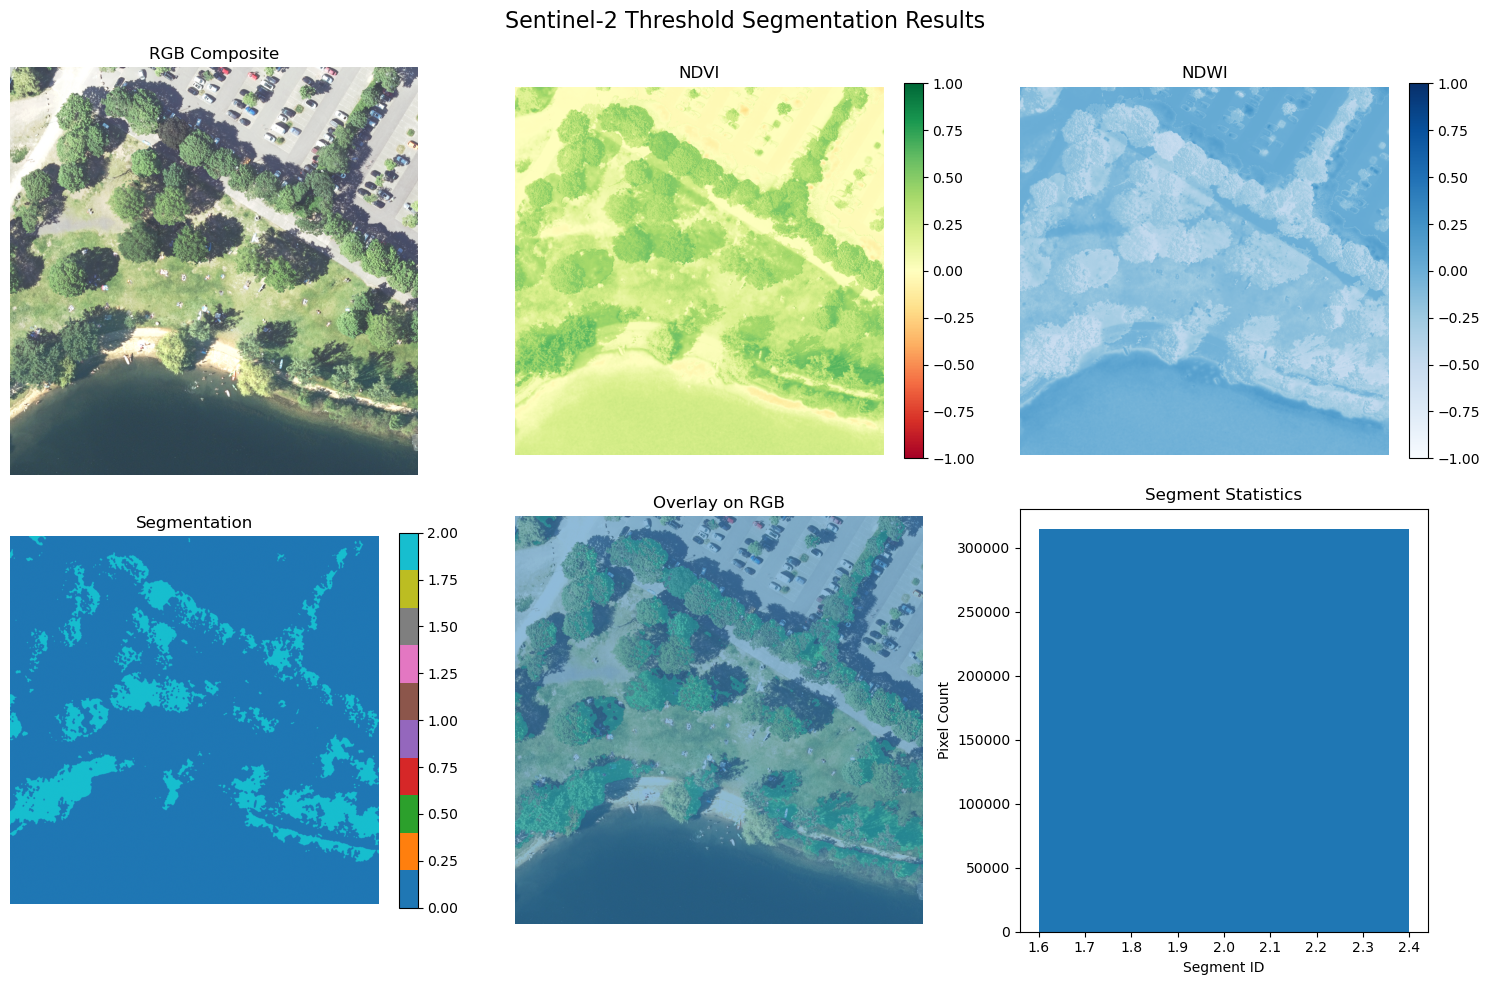


Segmentation Statistics:
segment_2: 314885 pixels, NDVI: 0.473, NDWI: -0.395


ImportError: cannot import name 'run_obia_statistics' from 'seg' (/Users/devseed/Documents/repos/OBIA_workflow/notebooks/seg.py)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage import measure
import rasterio
import seaborn as sns

class OBIAClassification:
    def __init__(self, image_path, segments=None, stats_df=None):
        """
        Initialize OBIA classification workflow
        
        Args:
            image_path: Path to Sentinel-2 image
            segments: Segmentation array
            stats_df: Pre-computed statistics dataframe
        """
        self.image_path = image_path
        self.segments = segments
        self.bands = {}
        self.indices = {}
        self.stats_df = stats_df
        self.feature_columns = []
        self.models = {}
        self.scalers = {}
        self.predictions = {}
        
    def load_image(self):
        """Load Sentinel-2 image"""
        print("Loading image for classification...")
        
        with rasterio.open(self.image_path) as src:
            self.bands['blue'] = src.read(3).astype(np.float32)
            self.bands['green'] = src.read(2).astype(np.float32)
            self.bands['red'] = src.read(1).astype(np.float32)
            self.bands['nir'] = src.read(4).astype(np.float32)
            
    def calculate_indices(self):
        """Calculate spectral indices"""
        # NDVI
        ndvi_num = self.bands['nir'] - self.bands['red']
        ndvi_den = self.bands['nir'] + self.bands['red']
        self.indices['ndvi'] = np.divide(ndvi_num, ndvi_den, 
                                       out=np.zeros_like(ndvi_num), 
                                       where=ndvi_den!=0)
        
        # NDWI
        ndwi_num = self.bands['green'] - self.bands['nir']
        ndwi_den = self.bands['green'] + self.bands['nir']
        self.indices['ndwi'] = np.divide(ndwi_num, ndwi_den,
                                       out=np.zeros_like(ndwi_num),
                                       where=ndwi_den!=0)
        
    def prepare_features(self):
        """Prepare feature matrix from statistics or direct calculation"""
        print("Preparing features...")
        
        if self.stats_df is not None:
            # Use pre-computed statistics
            feature_cols = [col for col in self.stats_df.columns 
                           if col not in ['object_id', 'class']]
            self.feature_columns = feature_cols
            features = self.stats_df[feature_cols].fillna(0)
            
        else:
            # Calculate features directly from segments
            if self.segments is None:
                # Create simple segmentation
                binary = self.indices['ndvi'] > 0.3
                from skimage import morphology
                binary = morphology.opening(binary, morphology.disk(3))
                self.segments = measure.label(binary)
            
            features_list = []
            objects = measure.regionprops(self.segments)
            
            for obj in objects:
                if obj.area < 10:
                    continue
                    
                mask = self.segments == obj.label
                
                # Basic spectral features
                feature_row = {
                    'object_id': obj.label,
                    'area': obj.area,
                    'red_mean': np.mean(self.bands['red'][mask]),
                    'green_mean': np.mean(self.bands['green'][mask]),
                    'blue_mean': np.mean(self.bands['blue'][mask]),
                    'nir_mean': np.mean(self.bands['nir'][mask]),
                    'ndvi_mean': np.mean(self.indices['ndvi'][mask]),
                    'ndwi_mean': np.mean(self.indices['ndwi'][mask]),
                    'compactness': (obj.perimeter ** 2) / (4 * np.pi * obj.area),
                    'eccentricity': obj.eccentricity,
                    'solidity': obj.solidity
                }
                features_list.append(feature_row)
            
            self.stats_df = pd.DataFrame(features_list)
            self.feature_columns = [col for col in self.stats_df.columns 
                                  if col != 'object_id']
            features = self.stats_df[self.feature_columns]
            
        return features
        
    def create_training_labels(self):
        """Create training labels using rule-based classification"""
        print("Creating training labels...")
        
        conditions = [
            (self.stats_df['ndvi_mean'] > 0.5) & (self.stats_df['nir_mean'] > 2000),
            (self.stats_df['ndwi_mean'] > 0.2) & (self.stats_df['ndvi_mean'] < 0.2),
            (self.stats_df['ndvi_mean'] < 0.2) & (self.stats_df['red_mean'] > self.stats_df['nir_mean']),
            (self.stats_df['ndvi_mean'] > 0.2) & (self.stats_df['ndvi_mean'] < 0.5)
        ]
        
        choices = ['Vegetation', 'Water', 'Built-up', 'Mixed']
        
        self.stats_df['labels'] = np.select(conditions, choices, default='Other')
        
        # Remove 'Other' class for training (too ambiguous)
        training_data = self.stats_df[self.stats_df['labels'] != 'Other'].copy()
        
        print(f"Training samples per class:")
        print(training_data['labels'].value_counts())
        
        return training_data
        
    def train_random_forest(self, features, labels):
        """Train Random Forest classifier"""
        print("Training Random Forest...")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.3, random_state=42, stratify=labels)
        
        # Train model
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        
        rf.fit(X_train, y_train)
        
        # Evaluate
        y_pred = rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Random Forest Accuracy: {accuracy:.3f}")
        
        # Store model and results
        self.models['random_forest'] = rf
        self.scalers['random_forest'] = None  # RF doesn't need scaling
        
        return rf, accuracy, y_test, y_pred
        
    def train_svm(self, features, labels):
        """Train SVM classifier"""
        print("Training SVM...")
        
        # Split and scale data
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.3, random_state=42, stratify=labels)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
        svm.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred = svm.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"SVM Accuracy: {accuracy:.3f}")
        
        # Store model and results
        self.models['svm'] = svm
        self.scalers['svm'] = scaler
        
        return svm, accuracy, y_test, y_pred
        
    def predict_all_objects(self):
        """Predict classes for all objects using trained models"""
        print("Predicting all objects...")
        
        features = self.stats_df[self.feature_columns].fillna(0)
        
        for model_name, model in self.models.items():
            if self.scalers[model_name] is not None:
                features_scaled = self.scalers[model_name].transform(features)
                predictions = model.predict(features_scaled)
            else:
                predictions = model.predict(features)
                
            self.stats_df[f'{model_name}_prediction'] = predictions
            self.predictions[model_name] = predictions
            
    def create_classification_maps(self):
        """Create classification maps"""
        if self.segments is None:
            print("No segments available for mapping")
            return
            
        classification_maps = {}
        
        for model_name in self.models.keys():
            class_map = np.zeros_like(self.segments)
            
            for idx, row in self.stats_df.iterrows():
                object_id = row['object_id']
                prediction = row[f'{model_name}_prediction']
                
                # Map class names to numbers for visualization
                class_mapping = {'Vegetation': 1, 'Water': 2, 'Built-up': 3, 'Mixed': 4, 'Other': 5}
                class_num = class_mapping.get(prediction, 0)
                
                class_map[self.segments == object_id] = class_num
                
            classification_maps[model_name] = class_map
            
        return classification_maps
        
    def plot_results(self, rf_results, svm_results):
        """Visualize classification results"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('OBIA Classification Results', fontsize=16)
        
        # Confusion matrices
        rf_cm = confusion_matrix(rf_results[2], rf_results[3])
        svm_cm = confusion_matrix(svm_results[2], svm_results[3])
        
        sns.heatmap(rf_cm, annot=True, fmt='d', ax=axes[0, 0], cmap='Blues')
        axes[0, 0].set_title('Random Forest Confusion Matrix')
        axes[0, 0].set_xlabel('Predicted')
        axes[0, 0].set_ylabel('Actual')
        
        sns.heatmap(svm_cm, annot=True, fmt='d', ax=axes[0, 1], cmap='Greens')
        axes[0, 1].set_title('SVM Confusion Matrix')
        axes[0, 1].set_xlabel('Predicted')
        axes[0, 1].set_ylabel('Actual')
        
        # Feature importance (Random Forest)
        if hasattr(self.models['random_forest'], 'feature_importances_'):
            importances = self.models['random_forest'].feature_importances_
            feature_names = self.feature_columns[:len(importances)]
            
            # Plot top 10 features
            indices = np.argsort(importances)[::-1][:10]
            axes[0, 2].bar(range(len(indices)), importances[indices])
            axes[0, 2].set_xticks(range(len(indices)))
            axes[0, 2].set_xticklabels([feature_names[i] for i in indices], rotation=45)
            axes[0, 2].set_title('Top 10 Feature Importances (RF)')
        
        # Classification distribution
        if 'random_forest_prediction' in self.stats_df.columns:
            rf_counts = self.stats_df['random_forest_prediction'].value_counts()
            axes[1, 0].pie(rf_counts.values, labels=rf_counts.index, autopct='%1.1f%%')
            axes[1, 0].set_title('Random Forest Predictions')
            
        if 'svm_prediction' in self.stats_df.columns:
            svm_counts = self.stats_df['svm_prediction'].value_counts()
            axes[1, 1].pie(svm_counts.values, labels=svm_counts.index, autopct='%1.1f%%')
            axes[1, 1].set_title('SVM Predictions')
        
        # Accuracy comparison
        accuracies = [rf_results[1], svm_results[1]]
        model_names = ['Random Forest', 'SVM']
        axes[1, 2].bar(model_names, accuracies, color=['blue', 'green'], alpha=0.7)
        axes[1, 2].set_ylabel('Accuracy')
        axes[1, 2].set_title('Model Comparison')
        axes[1, 2].set_ylim(0, 1)
        
        for i, v in enumerate(accuracies):
            axes[1, 2].text(i, v + 0.01, f'{v:.3f}', ha='center')
        
        plt.tight_layout()
        plt.show()
        
    def plot_classification_maps(self):
        """Plot classification maps"""
        if self.segments is None:
            print("No segments available for mapping")
            return
            
        maps = self.create_classification_maps()
        
        fig, axes = plt.subplots(1, len(maps) + 1, figsize=(15, 5))
        
        # Original RGB
        if hasattr(self, 'bands'):
            rgb = np.stack([self.bands['red'], self.bands['green'], self.bands['blue']], axis=2)
            rgb_norm = np.clip(rgb / np.percentile(rgb, 98), 0, 1)
            axes[0].imshow(rgb_norm)
            axes[0].set_title('Original RGB')
            axes[0].axis('off')
        
        # Classification maps
        colors = ['black', 'green', 'blue', 'red', 'yellow', 'gray']
        labels = ['Background', 'Vegetation', 'Water', 'Built-up', 'Mixed', 'Other']
        
        for i, (model_name, class_map) in enumerate(maps.items(), 1):
            im = axes[i].imshow(class_map, cmap='tab10', vmin=0, vmax=5)
            axes[i].set_title(f'{model_name.replace("_", " ").title()} Classification')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    def export_results(self, output_path):
        """Export classification results"""
        self.stats_df.to_csv(output_path, index=False)
        print(f"Classification results exported to {output_path}")
        
    def summary_report(self):
        """Generate classification summary"""
        print("\n=== OBIA CLASSIFICATION SUMMARY ===")
        print(f"Total objects classified: {len(self.stats_df)}")
        
        for model_name in self.models.keys():
            if f'{model_name}_prediction' in self.stats_df.columns:
                print(f"\n{model_name.replace('_', ' ').title()} Results:")
                counts = self.stats_df[f'{model_name}_prediction'].value_counts()
                for class_name, count in counts.items():
                    percentage = (count / len(self.stats_df)) * 100
                    print(f"  {class_name}: {count} objects ({percentage:.1f}%)")


# Main workflow function
def run_obia_classification(image_path, segments=None, stats_df=None):
    """
    Run complete OBIA classification workflow
    
    Args:
        image_path: Path to Sentinel-2 image
        segments: Optional segmentation array
        stats_df: Optional pre-computed statistics
    """
    
    # Initialize
    classifier = OBIAClassification(image_path, segments, stats_df)
    
    if stats_df is None:
        # Load and process if no stats provided
        classifier.load_image()
        classifier.calculate_indices()
    
    # Prepare features and labels
    features = classifier.prepare_features()
    training_data = classifier.create_training_labels()
    
    if len(training_data) < 20:
        print("Warning: Very few training samples. Results may be unreliable.")
        return classifier
    
    # Train models
    train_features = training_data[classifier.feature_columns]
    train_labels = training_data['labels']
    
    rf_results = classifier.train_random_forest(train_features, train_labels)
    svm_results = classifier.train_svm(train_features, train_labels)
    
    # Predict all objects
    classifier.predict_all_objects()
    
    # Visualize results
    classifier.plot_results(rf_results, svm_results)
    classifier.plot_classification_maps()
    classifier.summary_report()
    
    return classifier



# Step 1: Segmentation (creates the segments)
from seg import run_segmentation_workflow
segmenter = run_segmentation_workflow('/Users/devseed/Documents/repos/OBIA_workflow/data/ortho_subset_I.tif', method='threshold')
segments = segmenter.segments  # This is what you need!

# Step 2: Statistics (uses the segments)
from seg import run_obia_statistics
stats = run_obia_statistics('/Users/devseed/Documents/repos/OBIA_workflow/data/ortho_subset_I.tif', segments=segments)
stats_df = stats.stats_df

# Step 3: Classification (uses segments + statistics)
from your_classification_code import run_obia_classification
classifier = run_obia_classification('your_image.tif', segments=segments, stats_df=stats_df)
# Example usage:
classifier = run_obia_classification('/Users/devseed/Documents/repos/OBIA_workflow/data/ortho_subset_I.tif')
# classifier.export_results('classification_results.csv')